In [183]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.patches as patches

100 200


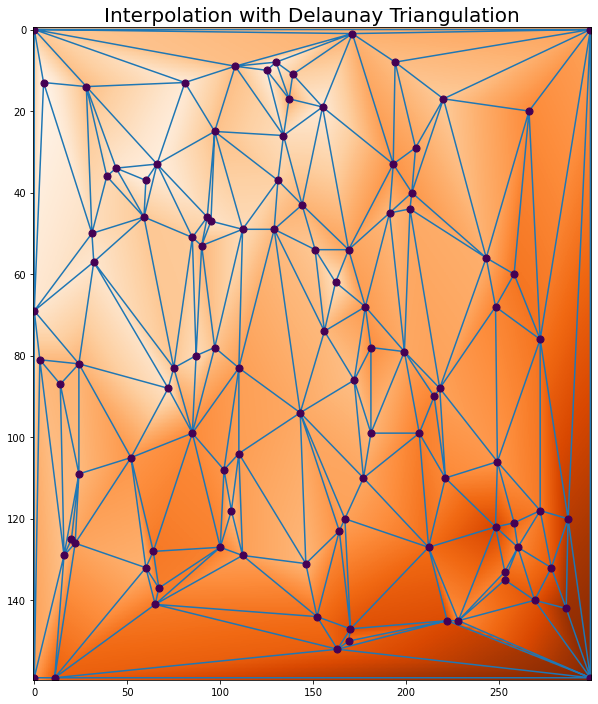

In [18]:
nx, ny = 160, 300

xv, yv = np.meshgrid(np.arange(nx), np.arange(ny))
xv = xv.flatten()
yv = yv.flatten()
pp = np.vstack((xv, yv)).T
    
n = 100

ix = np.random.choice(nx, n).tolist() + [0, 0, nx-1, nx-1]
iy = np.random.choice(ny, n).tolist() + [0, ny-1, 0, ny-1]
f = np.zeros((nx, ny))
for x, y in zip(ix, iy):
    f[x, y] = (x/160)**2 + (y/300)**2 + np.random.rand()
points = np.array(list(zip(ix, iy)))



tri = Delaunay(points)
ss = tri.find_simplex(pp)
ndim = tri.transform.shape[2]
print(n,len(np.unique(ss)))

out = np.zeros((nx, ny))
for i in np.unique(ss): # for all simplices (triangles)
    p = pp[ss == i] # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(p) - tri.transform[i, ndim].reshape(-1,1))
    αβγ = np.c_[np.transpose(b), 1 - b.sum(axis=0)] 
    sp = points[tri.simplices[i]]
    if len(αβγ) > 0:
        out[p[:,0], p[:,1]] = αβγ@f[sp[:,0], sp[:,1]]     
out = out / out.max()

plt.figure(figsize=(10,12))
plt.imshow(out, aspect='auto', cmap='Oranges'), plt.axis(), plt.title('interpolated output with\n barycentric coordinates', size=20)
plt.triplot(points[:,1], points[:,0], tri.simplices)
for p in points:
    plt.scatter(p[1], p[0], c=f[p[0],p[1]], s=50)
plt.title(f'Interpolation with Delaunay Triangulation', size=20)
plt.show()


In [178]:
info = np.loadtxt('E_field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]

# Load the csv file
df = pd.read_csv('E_field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist
z=Field[:,1]*convert_dist
Er=Field[:,2]*convert_E
Ez=Field[:,3]*convert_E

E = np.sqrt(Er**2 + Ez**2)


R = np.loadtxt('E_field/r.txt')*convert_dist
Z = np.loadtxt('E_field/z.txt')*convert_dist

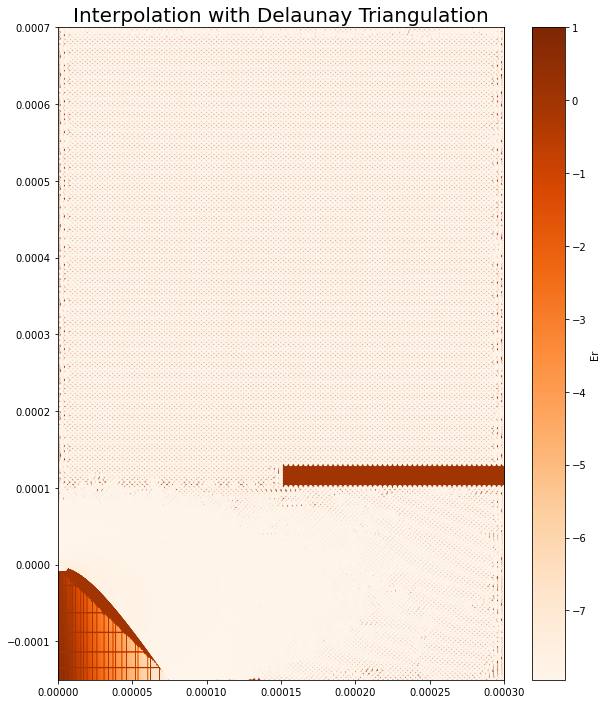

In [72]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pylab as plt

# Sort the data by (r, z) and get unique points with their corresponding Er values
data = sorted(zip(r, z, Er))
points, Er_values = np.array([(x[0], x[1]) for x in data]), np.array([x[2] for x in data])

# Create a grid for interpolation
r_min, r_max, nr = r.min(), r.max(), 500  # Adjust grid size as needed
z_min, z_max, nz = z.min(), z.max(), 500  # Adjust grid size as needed
r_lin = np.linspace(r_min, r_max, nr)
z_lin = np.linspace(z_min, z_max, nz)
rv, zv = np.meshgrid(r_lin, z_lin)

# Flatten and stack the grid points
pp = np.vstack((rv.flatten(), zv.flatten())).T

# Compute Delaunay triangulation of the data points
tri = Delaunay(points)

# Find the simplices containing each point in the grid
ss = tri.find_simplex(pp)

# For each point in the grid, compute its barycentric coordinates within
# its simplex, and use them to interpolate the function value
out = np.zeros_like(rv)
ndim = tri.transform.shape[2]
for i in np.unique(ss):  # for all simplices (triangles)
    p = pp[ss == i]  # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(p) - tri.transform[i, ndim].reshape(-1,1))
    αβγ = np.c_[np.transpose(b), 1 - b.sum(axis=0)] 
    # Here we need to use the indices of the points in the simplices, not the coordinates
    sp_indices = tri.simplices[i]
    # scale and shift the p coordinates to get indices
    ix = ((p[:, 0] - r_min) / (r_max - r_min) * (nr - 1)).astype(int)
    iy = ((p[:, 1] - z_min) / (z_max - z_min) * (nz - 1)).astype(int)
    if len(αβγ) > 0:
        out[ix, iy] = αβγ @ Er_values[sp_indices]
out = out / out.max()  # normalize for color scale

# Plot the interpolated function
plt.figure(figsize=(10,12))
plt.imshow(out.T, origin='lower', extent=[r_min, r_max, z_min, z_max], aspect='auto', cmap='Oranges')
plt.colorbar(label='Er')
plt.scatter(points[:, 0], points[:, 1], c=Er_values, s=10, cmap='Oranges')
plt.title('Interpolation with Delaunay Triangulation', size=20)
plt.show()


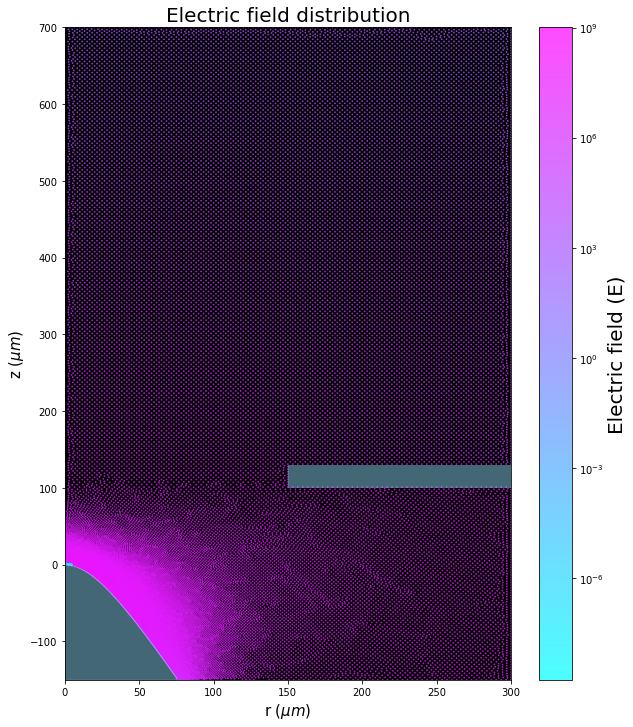

In [244]:


# Create a new figure with a black background
fig = plt.figure(figsize=(10,12), facecolor='white')
ax = fig.add_subplot(111, facecolor='black')

# Create a scatter plot
sc = ax.scatter(r*1e6, z*1e6, c=E, s=0.7, cmap='cool', norm=LogNorm(),alpha=0.7)

# Set the x and y limits to the minimum and maximum of the data
ax.set_xlim([r.min()*1e6, r.max()*1e6])
ax.set_ylim([z.min()*1e6, z.max()*1e6])

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Electric field (E)', size=20, color='black')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Set plot title and labels
ax.set_title('Electric field distribution', size=20, color='black')
ax.set_xlabel('r ($\mu m$)', size=15, color='black')
ax.set_ylabel('z ($\mu m$)', size=15, color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')


#Plot the grid surface
# Define the 4 points of the rectangle
p1 = (150, 100)
p2 = (150, 130)
p3 = (300, 100)
p4 = (300, 130)
width = p3[0]-p1[0]
height = p2[1]-p1[1]
# patches.Rectangle() needs the bottom left point, width and height
rect = patches.Rectangle((p1[0],p1[1]), width, height, facecolor ='skyblue', alpha=0.5)
# Add the patch to the Axes
ax.add_patch(rect)

#Plot the tip of the emitter
r_tip=np.arange(0,75,0.1)
d=100
Rc=11
eta0=np.power(1+Rc/d,-1/2)
a=2*d*np.sqrt(1+Rc/d)
z_tip=100-eta0*np.sqrt(np.power(a,2)/4+np.power(r_tip,2)/(1-np.power(eta0,2)))
plt.fill_between(r_tip, z_tip,-150, color='skyblue', alpha=0.5)

# Show the plot
plt.show()

